*italicized text*# MNIST Digit Interpolation
 Steps
 

1.   Train auto-encoder recreate pictures of digits from MNIST dataset
2.   Interpolate any two elements of MNIST with learned embeddings



# Initializing and training model

In [2]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np

from matplotlib import pyplot as plt

In [2]:
class NormalizeImage(object):
  """
  Transform to normalize mean and std of pixel values (better for training)
  """
  def __call__(self, image):
    """
    Parameters:
      image has shape (1, height, width)
    Returns:
      same image but where the contents of each image have been normalized to mean 0 std 1
    """
    height, width = image.shape[1], image.shape[2]
    _image = image.reshape(height, width)
    mean, std = torch.mean(_image), torch.std(_image)
    return (_image - mean)/std

In [3]:
# dataset
transform = transforms.Compose([transforms.ToTensor(), NormalizeImage()])
training_set = tv.datasets.MNIST(root = './data', train = True, download = True, transform=transform)
dataloader = torch.utils.data.DataLoader(training_set, batch_size=32, shuffle=False, num_workers=4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [4]:
class PrintModule(nn.Module):
  def __init__(self, message):
    super().__init__()
    self.message = message

  def forward(self, x):
    print(self.message)
    return x

class AutoEncoder(nn.Module):

  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Conv2d(1, 8, 3, stride=2, padding=1),
        nn.ReLU(True),
        nn.Conv2d(8, 16, 3, stride=2, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(True),
        nn.Conv2d(16, 32, 3, stride=2, padding=0),
        nn.ReLU(True),
        nn.Flatten(start_dim=1),
        nn.Linear(3 * 3 * 32, 128),
        nn.ReLU(True),
        nn.Linear(128, 16),
    )

    self.decoder = nn.Sequential(
        nn.Linear(16, 128),
        nn.ReLU(True),
        nn.Linear(128, 3 * 3 * 32),
        nn.ReLU(True),
        nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3)),
        nn.ConvTranspose2d(32, 16, 3, 
        stride=2, output_padding=0),
        nn.BatchNorm2d(16),
        nn.ReLU(True),
        nn.ConvTranspose2d(16, 8, 3, stride=2, 
        padding=1, output_padding=1),
        nn.BatchNorm2d(8),
        nn.ReLU(True),
        nn.ConvTranspose2d(8, 1, 3, stride=2, 
        padding=1, output_padding=1)
    )
  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)
    return torch.sigmoid(x)


In [5]:
# Defining Parameters

num_epochs = 5
batch_size = 32
model = AutoEncoder().cpu()
distance = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),weight_decay=1e-5)

for epoch in range(num_epochs):
    for data in dataloader:
        #note, img from dataloader has dimensions 32x28x28 (batch size is 32)
        #Conv2d input shape is 32x1x28x28 (batch_size x num_channels x width x height)
        img, _ = data
        img = img.reshape(batch_size, -1, 28, 28)
        img = torch.autograd.Variable(img).cpu()
        # ===================forward=====================
        output = model(img)
        loss = distance(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch+1, num_epochs, loss.item()))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch [1/5], loss:0.5594
epoch [2/5], loss:0.5488
epoch [3/5], loss:0.5440
epoch [4/5], loss:0.5396
epoch [5/5], loss:0.5393


# Viewing results

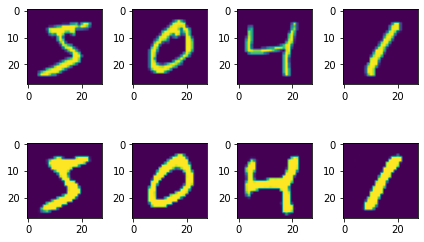

In [6]:
def get_recreated_image(img):
  img = img.reshape(1, 1, 28, 28)
  after_img = model(img).reshape(28,28).detach().numpy()
  return after_img

def show_examples(num_examples = 10):
  fig, ax = plt.subplots(2, num_examples)
  for img_idx in range(num_examples):
    img = training_set[img_idx][0] # 0 for Tensor, 1 for label
    after_img = get_recreated_image(img)
    ax[0, img_idx].imshow(img)
    ax[1, img_idx].imshow(after_img)
  plt.tight_layout()
  plt.show()

show_examples(4)

# Interpolation

In [16]:
def interpolate(start_img, end_img, num_frames = 5):
  _start_img = start_img.reshape(1, 1, 28, 28)
  _end_img = end_img.reshape(1, 1, 28, 28)
  latent_start_img = model.encoder(_start_img)
  latent_end_img = model.encoder(_end_img)
  
  frame_fade_levels = np.linspace(0, 1, num_frames)
  latent_img_frames = [(1-fade_level) * latent_start_img + fade_level * latent_end_img for fade_level in frame_fade_levels]
  decoded_img_frames = list(map(lambda latent_img_frame: torch.sigmoid(model.decoder(latent_img_frame)), latent_img_frames))
  return list(map(lambda decoded_img_frame: decoded_img_frame.reshape(28, 28).detach().numpy(), decoded_img_frames))

def display_interpolation(start_img, end_img, num_frames = 5):
  frames = interpolate(start_img, end_img, num_frames)
  fig, axes = plt.subplots(1, num_frames)
  fig.set_figwidth(5 * num_frames)
  for idx, frame in enumerate(frames):
    axes[idx].imshow(frame)
  plt.show()

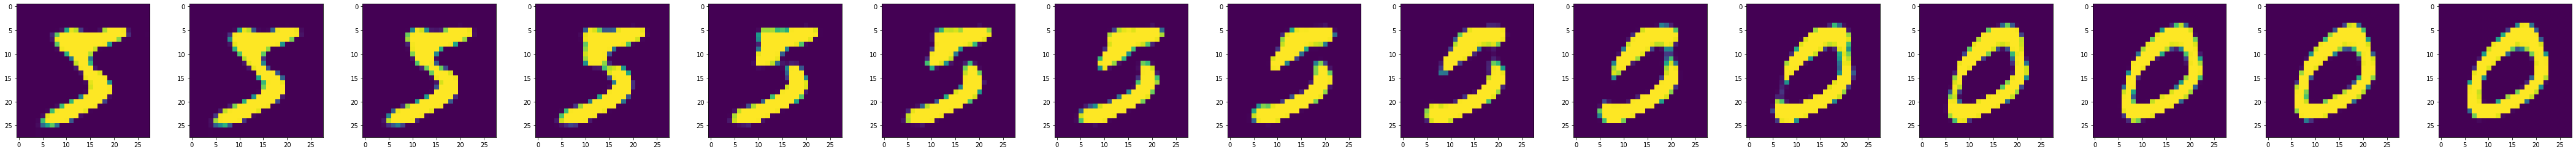

In [18]:
start_img = training_set[0][0]
end_img = training_set[1][0]
num_frames = 15
display_interpolation(start_img, end_img, num_frames)